In [1]:
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import numpy as np
import xarray as xr
from matplotlib.lines import Line2D
from palettable.colorbrewer.qualitative import Pastel1_4
from xarrayMannKendall import *

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '../results/'

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:41155 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 24 Memory: 250.00 GiB


# Loading datasets

In [2]:
# JRA55do-v14
uas = {}
vas = {}
uas['JRA'] = xr.open_dataset('/scratch/e14/jn8053/jra55/uas-v14-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice('1958-01-01', '2015-01-01'))
vas['JRA'] = xr.open_dataset('/scratch/e14/jn8053/jra55/vas-v14-monthly-1958_2019.nc').sel(lat = slice(None, -50)).sel(time = slice('1958-01-01', '2015-01-01'))

# CMIP6 multimodel mean
uas['CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/uas-hist-monthly-1958_2015.nc')
vas['CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/vas-hist-monthly-1958_2015.nc')

# CMIP6 multimodel std
uas_std_cmip = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/uas-hist-std-1958_2015.nc')
vas_std_cmip = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/vas-hist-std-1958_2015.nc')

In [3]:
# CMIP6 individual models
path_uas = glob.glob('/scratch/e14/jn8053/cmip6/historical/uas/uas*')
path_vas = glob.glob('/scratch/e14/jn8053/cmip6/historical/vas/vas*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas[model_name] = xr.open_dataset(path_uas[i])
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas[model_name] = xr.open_dataset(path_vas[i])
model_names = list(uas.keys())

In [4]:
shelf_mask = xr.open_dataset('~/g_e14/misc/Antarctic_shelf_mask.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
hu = hu.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
hu['_lon_adj'] = xr.where(hu['lon'] < 0, hu['lon'] + 360, hu['lon'])
hu = hu.swap_dims({'lon': '_lon_adj'})
hu = hu.sel(**{'_lon_adj': sorted(hu._lon_adj)}).drop('lon')
hu = hu.rename({'_lon_adj': 'lon'})

In [11]:
shelf_regions = xr.open_dataset('~/g_e14/misc/Antarctic_shelf_basins.nc')
basins = shelf_regions['basins'].where(shelf_regions['basins'] != 100, np.nan)
basins = basins.rename(({'xt_ocean':'x', 'yt_ocean':'y'}))
basins['_lon_adj'] = xr.where(basins['x'] < 0, basins['x'] + 360, basins['x'])
basins = basins.swap_dims({'x': '_lon_adj'})
basins = basins.sel(**{'_lon_adj': sorted(basins._lon_adj)}).drop('x')
basins = basins.rename({'_lon_adj': 'x'})
locs = list(shelf_regions['basin_lookup']['region'][:-1].values)
locs.remove('East Antarctica 04')

# Mean of historical period

In [29]:
def figure_1():
    fig = plt.figure(figsize = (15, 10))
    gr = gs.GridSpec(3, 3, figure = fig, width_ratios = [1, 1, .03])
    axs = [fig.add_subplot(gr[0,0]),
           fig.add_subplot(gr[0,1]),
           fig.add_subplot(gr[1,0]),
           fig.add_subplot(gr[1,1]),
           fig.add_subplot(gr[2,0]),
           fig.add_subplot(gr[2,1]),
           fig.add_subplot(gr[0,2]),
           fig.add_subplot(gr[1,2]),
           fig.add_subplot(gr[2,2])]
    for ax, label in zip(axs[:6], ['a)', 'b)', 'c)', 'd)', 'e)', 'f)']):
        ax.text(-0.08, .95, label, transform=ax.transAxes, size = 12, weight='bold')
        ax.contour(hu['lon'], hu['lat'], hu, levels = [1000, 3000], colors = 'k', linewidths = 0.5, zorder = 2)
        ax.set_ylim(-80, -60)
        ax.set_yticks(np.arange(-80, -60, 5))

    plt.tight_layout()
    
    return fig, axs

In [10]:
uas_jra_mean = uas['JRA']['uas'].mean('time').interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
vas_jra_mean = vas['JRA']['vas'].mean('time').interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
uas_cmip6_mean = uas['CMIP6']['uas'].mean('time').interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
vas_cmip6_mean = vas['CMIP6']['vas'].mean('time').interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
uas_cmip6_sdev = uas_std_cmip['uas'].mean('time').interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
vas_cmip6_sdev = vas_std_cmip['vas'].mean('time').interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])

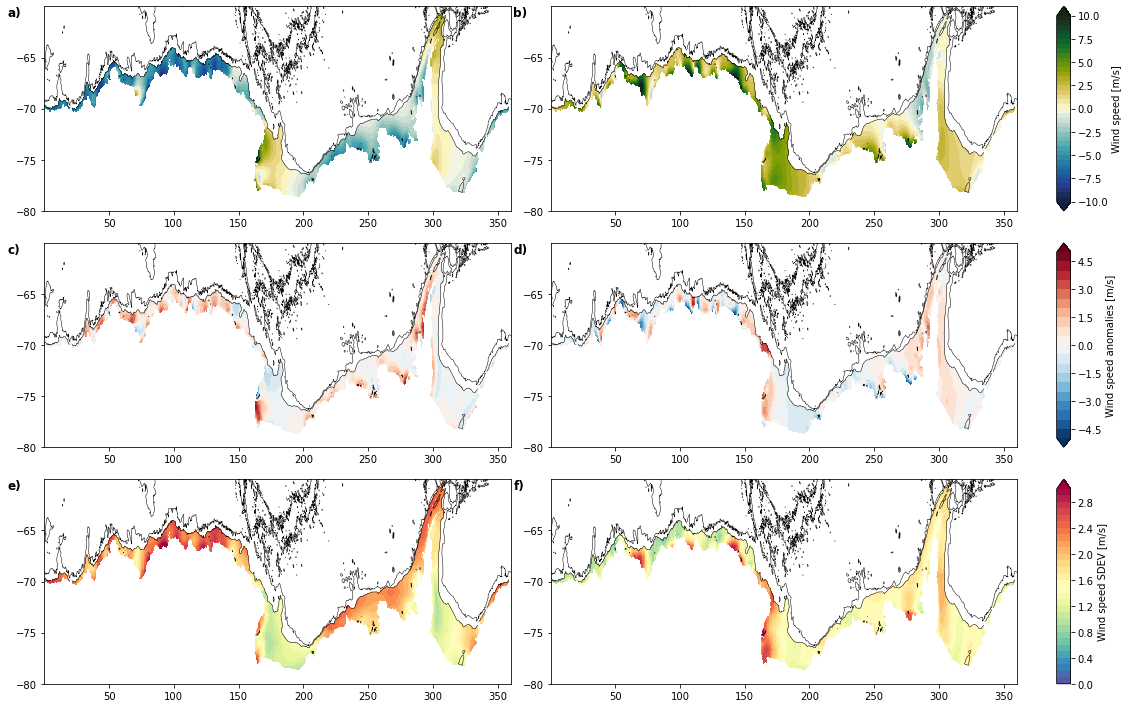

In [30]:
fig, axs = figure_1()
cf = axs[0].contourf(uas_jra_mean['lon'], uas_jra_mean['lat'], uas_jra_mean*shelf_mask, levels = np.arange(-10, 10.5, .5),
                     cmap = cmocean.cm.delta, extend = 'both')
axs[1].contourf(vas_jra_mean['lon'], vas_jra_mean['lat'], vas_jra_mean*shelf_mask, levels = np.arange(-10, 10.5, .5),
                cmap = cmocean.cm.delta, extend = 'both')
fig.colorbar(cf, cax = axs[6]).set_label('Wind speed [m/s]')
cf = axs[2].contourf(uas_jra_mean['lon'], uas_jra_mean['lat'], (uas_cmip6_mean - uas_jra_mean)*shelf_mask, 
                     levels = np.arange(-5, 5.5, .5), cmap = 'RdBu_r', extend = 'both')
axs[3].contourf(vas_jra_mean['lon'], vas_jra_mean['lat'], (vas_cmip6_mean - vas_jra_mean)*shelf_mask,
                levels = np.arange(-5, 5.5, .5), cmap = 'RdBu_r', extend = 'both')
fig.colorbar(cf, cax = axs[7]).set_label('Wind speed anomalies [m/s]')
axs[4].contourf(uas_jra_mean['lon'], uas_jra_mean['lat'], uas_cmip6_sdev*shelf_mask, 
                levels = np.arange(0, 3.1, .1), cmap = 'Spectral_r', extend = 'max')
cf = axs[5].contourf(vas_jra_mean['lon'], vas_jra_mean['lat'], vas_cmip6_sdev*shelf_mask,
                     levels = np.arange(0, 3.1, .1), cmap = 'Spectral_r', extend = 'max')
fig.colorbar(cf, cax = axs[8]).set_label('Wind speed SDEV [m/s]')
plt.savefig(figdir+'jramean_cmip6mean_cmip6sdev.png', facecolor = 'white', bbox_inches = 'tight')

# Historical trends

Full trends on shelf for maps

In [6]:
MK_trends_uas = {}
MK_trends_vas = {}
for n in model_names:
    u = uas[n]['uas']
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    MK_trends_uas[n] = MK_class.compute()
    
    v = vas[n]['vas']
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    MK_trends_vas[n] = MK_class.compute()

In [10]:
uas_jra_trend = MK_trends_uas['JRA'].interp(x = shelf_mask['lon'], y = shelf_mask['lat'])
vas_jra_trend = MK_trends_vas['JRA'].interp(x = shelf_mask['lon'], y = shelf_mask['lat'])
uas_cmip6_trend = MK_trends_uas['CMIP6'].interp(x = shelf_mask['lon'], y = shelf_mask['lat'])
vas_cmip6_trend = MK_trends_vas['CMIP6'].interp(x = shelf_mask['lon'], y = shelf_mask['lat'])

Individual trends per region for boxplot

In [11]:
uas_reg_trends = np.empty([len(model_names), len(locs)])
vas_reg_trends = np.empty([len(model_names), len(locs)])
for i in range(len(model_names)):
    u = MK_trends_uas[model_names[i]]['trend'].interp(x = basins['x'], y = basins['y'])
    v = MK_trends_vas[model_names[i]]['trend'].interp(x = basins['x'], y = basins['y'])
    for j in range(len(locs)):
        uas_reg_trends[i, j] = u.where(basins == j+2, np.nan).mean(['x', 'y'])
        vas_reg_trends[i, j] = v.where(basins == j+2, np.nan).mean(['x', 'y'])

Plot

In [63]:
def figure_2():
    fig = plt.figure(figsize = (15, 8))
    gr = gs.GridSpec(3, 3, figure = fig, width_ratios = [1, 1, .03], wspace = 0.3)
    axs = [fig.add_subplot(gr[0,0]),
           fig.add_subplot(gr[0,1]),
           fig.add_subplot(gr[1,0]),
           fig.add_subplot(gr[1,1]),
           fig.add_subplot(gr[2,0]),
           fig.add_subplot(gr[2,1]),
           fig.add_subplot(gr[:2,2])]
    for ax, label in zip(axs[:4], ['a)', 'b)', 'c)', 'd)']):
        ax.text(-0.08, .95, label, transform=ax.transAxes, size = 12, weight='bold')
        ax.contour(hu['lon'], hu['lat'], hu, levels = [1000, 3000], colors = 'k', linewidths = 0.5, zorder = 2)
        ax.set_ylim(-80, -60)
        ax.set_yticks(np.arange(-80, -60, 5))
    axs[4].text(-0.08, .95, 'e)', transform=axs[4].transAxes, size = 12, weight='bold')
    axs[5].text(-0.08, .95, 'f)', transform=axs[5].transAxes, size = 12, weight='bold')
    
    return fig, axs

In [37]:
legend_elements = [Line2D([0], [0], color = 'none', marker = 'd', markeredgecolor = 'r', markerfacecolor = 'r', label = 'JRA55-do mean'),
                   Line2D([0], [0], color = 'none', marker = 'o', markeredgecolor = 'r', markerfacecolor = 'none', label = 'CMIP6 mean')]

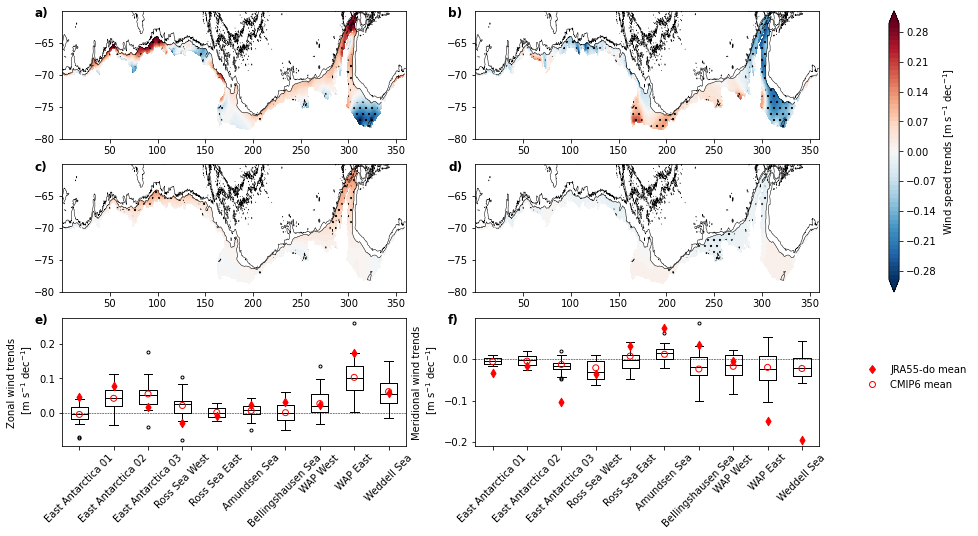

In [64]:
fig, axs = figure_2()
cf = axs[0].contourf(uas_jra_trend['x'], uas_jra_trend['y'], uas_jra_trend['trend']*shelf_mask*120, levels = np.arange(-.3, .31, .01),
                     cmap = 'RdBu_r', extend = 'both')
axs[0].contourf(uas_jra_trend['x'], uas_jra_trend['y'], uas_jra_trend['p'].where(uas_jra_trend['p'] <= .05)*shelf_mask, colors = ['none'], hatches = ['..'])
cf = axs[1].contourf(vas_jra_trend['x'], vas_jra_trend['y'], vas_jra_trend['trend']*shelf_mask*120, levels = np.arange(-.3, .31, .01),
                     cmap = 'RdBu_r', extend = 'both')
axs[1].contourf(vas_jra_trend['x'], vas_jra_trend['y'], vas_jra_trend['p'].where(vas_jra_trend['p'] <= .05)*shelf_mask, colors = ['none'], hatches = ['..'])

cf = axs[2].contourf(uas_cmip6_trend['x'], uas_cmip6_trend['y'], uas_cmip6_trend['trend']*shelf_mask*120, levels = np.arange(-.3, .31, .01),
                     cmap = 'RdBu_r', extend = 'both')
axs[2].contourf(uas_cmip6_trend['x'], uas_cmip6_trend['y'], uas_cmip6_trend['p'].where(uas_cmip6_trend['p'] <= .05)*shelf_mask, colors = ['none'], hatches = ['..'])
cf = axs[3].contourf(vas_cmip6_trend['x'], vas_cmip6_trend['y'], vas_cmip6_trend['trend']**shelf_mask*120, levels = np.arange(-.3, .31, .01),
                     cmap = 'RdBu_r', extend = 'both')
axs[3].contourf(vas_cmip6_trend['x'], vas_cmip6_trend['y'], vas_cmip6_trend['p'].where(vas_cmip6_trend['p'] <= .05)*shelf_mask, colors = ['none'], hatches = ['..'])
fig.colorbar(cf, cax = axs[6]).set_label('Wind speed trends [m s$^{-1}$ dec$^{-1}$]')

axs[4].axhline(y = 0, color = 'k', linestyle = '--', linewidth = 0.5, zorder = 0)
axs[4].boxplot(uas_reg_trends[2:,:]*120, sym = '.', medianprops=dict(color = 'k'), labels = locs, zorder = 1);
axs[4].scatter(np.arange(1,11,1), uas_reg_trends[0,:]*120, color = 'r', marker = 'd', zorder = 2)
axs[4].scatter(np.arange(1,11,1), uas_reg_trends[1,:]*120, color = 'r', marker = 'o', facecolor = 'none', zorder = 2)
axs[4].set_xticklabels(labels = locs, rotation = 45);
axs[4].set_ylabel('Zonal wind trends \n [m s$^{-1}$ dec$^{-1}$]')
axs[5].axhline(y = 0, color = 'k', linestyle = '--', linewidth = 0.5, zorder = 0)
axs[5].boxplot(vas_reg_trends[2:,:]*120, sym = '.', medianprops=dict(color = 'k'), labels = locs, zorder = 1);
axs[5].scatter(np.arange(1,11,1), vas_reg_trends[0,:]*120, color = 'r', marker = 'd', zorder = 2)
axs[5].scatter(np.arange(1,11,1), vas_reg_trends[1,:]*120, color = 'r', marker = 'o', facecolor = 'none', zorder = 2)
axs[5].set_ylabel('Meridional wind trends \n [m s$^{-1}$ dec$^{-1}$]')
axs[5].set_xticklabels(labels = locs, rotation = 45);

axs[5].legend(handles = legend_elements, bbox_to_anchor = (1.1, .7), frameon = False)
plt.savefig(figdir+'jratrend_cmip6trend_boxplots.png', facecolor = 'white', bbox_inches = 'tight')

# Per season

In [6]:
uas_seasonal = {}; vas_seasonal = {}
for n in model_names:
    uas_seasonal[n] = uas[n].groupby('time.season').mean('time').interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
    vas_seasonal[n] = vas[n].groupby('time.season'DJ).mean('time').interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
    print(n)

JRA
CMIP6
INM-CM4-8
NESM3
INM-CM5-0
FGOALS-f3-L
GFDL-ESM4
EC-Earth3-CC
EC-Earth3-Veg
IITM-ESM
EC-Earth3
EC-Earth3-Veg-LR
AWI-CM-1-1-MR
CanESM5
KACE-1-0-G
MPI-ESM1-2-LR
MPI-ESM1-2-HR
BCC-CSM2-MR
GFDL-CM4
IPSL-CM6A-LR
MRI-ESM2-0
MIROC6


In [7]:
basins = basins.rename({'x':'lon', 'y':'lat'})
basins = basins.interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])

In [9]:
uas_seasonal_reg = {}
vas_seasonal_reg = {}
for s in ['DJF', 'MAM', 'JJA', 'SON']:
    uas_seasonal_reg[s] = np.empty([len(model_names), len(locs)])
    vas_seasonal_reg[s] = np.empty([len(model_names), len(locs)])
    for i in range(len(model_names)):
        for j in range(len(locs)):
            uas_seasonal_reg[s][i, j] = uas_seasonal[model_names[i]]['uas'].sel(season = s).where(basins == j+2, np.nan).mean(['lon', 'lat'])
            vas_seasonal_reg[s][i, j] = vas_seasonal[model_names[i]]['vas'].sel(season = s).where(basins == j+2, np.nan).mean(['lon', 'lat'])

In [88]:
def figure_3():
    fig = plt.figure(figsize = (18, 10))
    gr = gs.GridSpec(2, 1, figure = fig)
    axs = [fig.add_subplot(gr[0,0]),
           fig.add_subplot(gr[1,0])]
    for ax, label in zip(axs, ['a)', 'b)']):
        ax.text(-0.05, .95, label, transform = ax.transAxes, size = 12, weight='bold')
        ax.axhline(y = 0, color = 'k', linestyle = '--', linewidth = 0.5, zorder = 0)
    axs[0].set_ylabel('Zonal wind speed [m/s]', fontsize = 12)
    axs[1].set_ylabel('Meridional wind speed [m/s]', fontsize = 12)
    return fig, axs

In [34]:
legend_elements = [Line2D([0], [0], color = 'none', marker = 'd', markeredgecolor = 'r', markerfacecolor = 'r', label = 'JRA55-do mean'),
                   Line2D([0], [0], color = 'none', marker = 'o', markeredgecolor = 'r', markerfacecolor = 'none', label = 'CMIP6 mean'),
                   mpatches.Patch(color = Pastel1_4.mpl_colors[0], label = 'DJF'),
                   mpatches.Patch(color = Pastel1_4.mpl_colors[1], label = 'MAM'),
                   mpatches.Patch(color = Pastel1_4.mpl_colors[2], label = 'JJA'),
                   mpatches.Patch(color = Pastel1_4.mpl_colors[3], label = 'SON')]

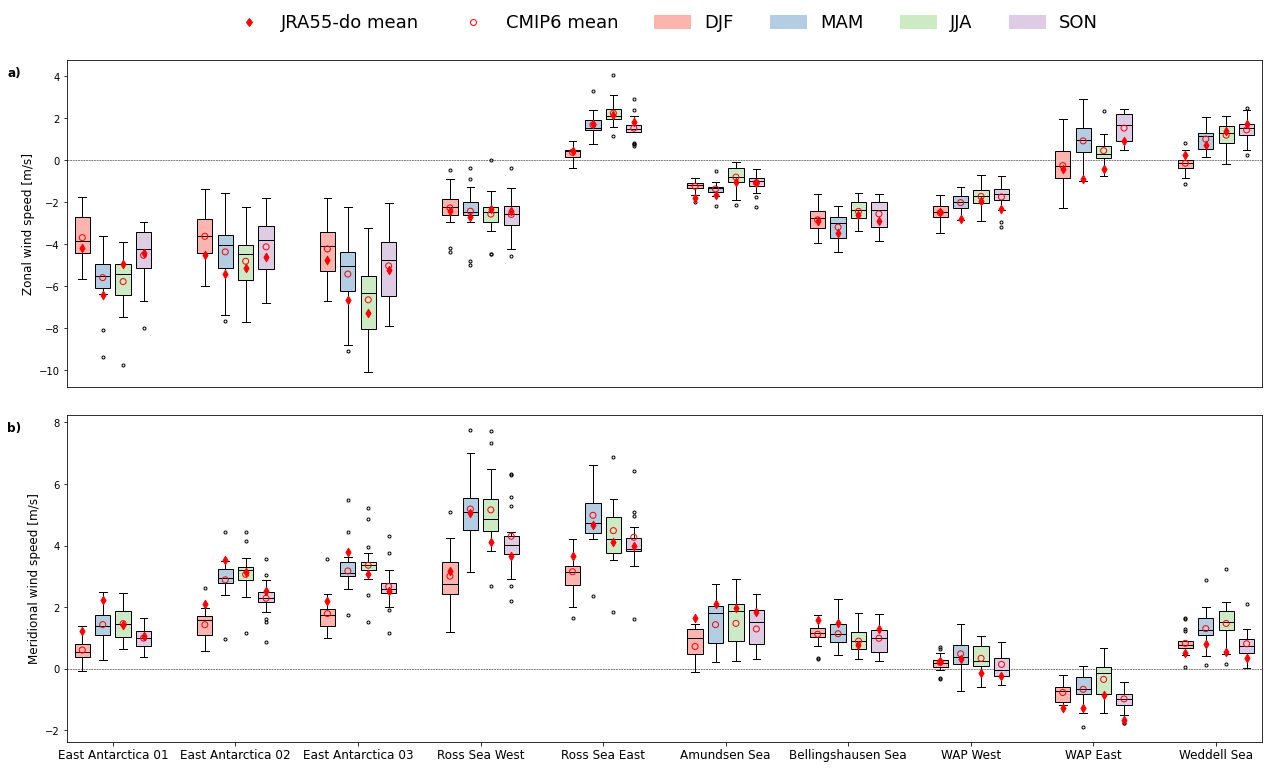

In [89]:
fig, axs = figure_3()
n = 0
for s in ['DJF', 'MAM', 'JJA', 'SON']:
    bp1 = axs[0].boxplot(uas_seasonal_reg[s][2:,:], positions = np.arange(0,40,4)+n/1.5, sym = '.', medianprops = dict(color = 'k'), 
                        patch_artist = True,zorder = 1);
    axs[0].scatter(np.arange(0,40,4)+n/1.5, uas_seasonal_reg[s][0,:], color = 'r', marker = 'd', zorder = 2)
    axs[0].scatter(np.arange(0,40,4)+n/1.5, uas_seasonal_reg[s][1,:], color = 'r',marker = 'o', facecolor = 'none', zorder = 2)
    
    bp2 = axs[1].boxplot(vas_seasonal_reg[s][2:,:], positions = np.arange(0,40,4)+n/1.5, sym = '.', medianprops = dict(color = 'k'), 
                         patch_artist = True, zorder = 1);
    axs[1].scatter(np.arange(0,40,4)+n/1.5, vas_seasonal_reg[s][0,:], color = 'r', marker = 'd', zorder = 2)
    axs[1].scatter(np.arange(0,40,4)+n/1.5, vas_seasonal_reg[s][1,:], color = 'r',marker = 'o', facecolor = 'none', zorder = 2)
    
    for bplot in (bp1, bp2):
        for patch, color in zip(bplot['boxes'], [Pastel1_4.mpl_colors[n]]*10):
            patch.set_facecolor(Pastel1_4.mpl_colors[n])
    n+=1
    plt.tight_layout()
axs[0].set_xticks([])
axs[0].set_xticklabels([]);
axs[1].set_xticks(np.arange(1, 41, 4))
axs[1].set_xticklabels(locs, fontsize = 12);
plt.legend(ncol = 6, handles = legend_elements, bbox_to_anchor = (0.5, 2.2), frameon = False, loc = 'center', fontsize = 18);
plt.savefig(figdir+'jramean_cmip6mean_reg_boxplots_seasonal.png', facecolor = 'white', bbox_inches = 'tight')

In [7]:
uas_djf = {}; uas_mam = {}; uas_jja = {}; uas_son = {}
for n in model_names:
    uas_djf[n] = uas[n]['uas'].where(uas[n]['time.season'] == 'DJF', drop = True).isel(time = slice(2, -1))
    uas_mam[n] = uas[n]['uas'].where(uas[n]['time.season'] == 'MAM', drop = True).isel(time = slice(3, None))
    uas_jja[n] = uas[n]['uas'].where(uas[n]['time.season'] == 'JJA', drop = True).isel(time = slice(3, None))
    uas_son[n] = uas[n]['uas'].where(uas[n]['time.season'] == 'SON', drop = True).isel(time = slice(3, None))
    print(n)

JRA
CMIP6
INM-CM4-8
NESM3
INM-CM5-0
FGOALS-f3-L
GFDL-ESM4
EC-Earth3-CC
EC-Earth3-Veg
IITM-ESM
EC-Earth3
EC-Earth3-Veg-LR
AWI-CM-1-1-MR
CanESM5
KACE-1-0-G
MPI-ESM1-2-LR
MPI-ESM1-2-HR
BCC-CSM2-MR
GFDL-CM4
IPSL-CM6A-LR
MRI-ESM2-0
MIROC6


In [8]:
vas_djf = {}; vas_mam = {}; vas_jja = {}; vas_son = {}
for n in model_names:
    vas_djf[n] = vas[n]['vas'].where(vas[n]['time.season'] == 'DJF', drop = True).isel(time = slice(2, -1))
    vas_mam[n] = vas[n]['vas'].where(vas[n]['time.season'] == 'MAM', drop = True).isel(time = slice(3, None))
    vas_jja[n] = vas[n]['vas'].where(vas[n]['time.season'] == 'JJA', drop = True).isel(time = slice(3, None))
    vas_son[n] = vas[n]['vas'].where(vas[n]['time.season'] == 'SON', drop = True).isel(time = slice(3, None))
    print(n)

JRA
CMIP6
INM-CM4-8
NESM3
INM-CM5-0
FGOALS-f3-L
GFDL-ESM4
EC-Earth3-CC
EC-Earth3-Veg
IITM-ESM
EC-Earth3
EC-Earth3-Veg-LR
AWI-CM-1-1-MR
CanESM5
KACE-1-0-G
MPI-ESM1-2-LR
MPI-ESM1-2-HR
BCC-CSM2-MR
GFDL-CM4
IPSL-CM6A-LR
MRI-ESM2-0
MIROC6


In [10]:
MK_trends_uas_djf = {}
MK_trends_uas_mam = {}
MK_trends_uas_jja = {}
MK_trends_uas_son = {}
for n in model_names:
    u = uas_djf[n]
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    MK_trends_uas_djf[n] = MK_class.compute()
    
    u = uas_mam[n]
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    MK_trends_uas_mam[n] = MK_class.compute()
    
    u = uas_jja[n]
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    MK_trends_uas_jja[n] = MK_class.compute()
    
    u = uas_son[n]
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    MK_trends_uas_son[n] = MK_class.compute()
    print(n)

distributed.nanny - WARNING - Restarting worker


JRA
CMIP6
INM-CM4-8
NESM3
INM-CM5-0
FGOALS-f3-L
GFDL-ESM4
EC-Earth3-CC
EC-Earth3-Veg
IITM-ESM
EC-Earth3
EC-Earth3-Veg-LR
AWI-CM-1-1-MR
CanESM5
KACE-1-0-G
MPI-ESM1-2-LR
MPI-ESM1-2-HR
BCC-CSM2-MR
GFDL-CM4
IPSL-CM6A-LR
MRI-ESM2-0
MIROC6


In [27]:
MK_trends_vas_djf = {}
MK_trends_vas_mam = {}
MK_trends_vas_jja = {}
MK_trends_vas_son = {}
for n in model_names:
    u = vas_djf[n]
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    MK_trends_vas_djf[n] = MK_class.compute()
    
    u = vas_mam[n]
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    MK_trends_vas_mam[n] = MK_class.compute()
    
    u = vas_jja[n]
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    MK_trends_vas_jja[n] = MK_class.compute()
    
    u = vas_son[n]
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'time':'time', 'lat':'y', 'lon':'x'})
    MK_trends_vas_son[n] = MK_class.compute()
    print(n)

JRA
CMIP6
INM-CM4-8
NESM3
INM-CM5-0
FGOALS-f3-L
GFDL-ESM4
EC-Earth3-CC
EC-Earth3-Veg
IITM-ESM
EC-Earth3
EC-Earth3-Veg-LR
AWI-CM-1-1-MR
CanESM5
KACE-1-0-G
MPI-ESM1-2-LR
MPI-ESM1-2-HR
BCC-CSM2-MR
GFDL-CM4
IPSL-CM6A-LR
MRI-ESM2-0
MIROC6


In [28]:
uas_seasonal_trends_reg = {}
vas_seasonal_trends_reg = {}
s = 'DJF'
uas_seasonal_trends_reg[s] = np.empty([len(model_names), len(locs)])
vas_seasonal_trends_reg[s] = np.empty([len(model_names), len(locs)])
for i in range(len(model_names)):
    for j in range(len(locs)):
        u = MK_trends_uas_djf[model_names[i]].interp(x = basins['x'], y = basins['y'])
        uas_seasonal_trends_reg[s][i, j] = u['trend'].where(basins == j+2, np.nan).mean(['x', 'y'])
        v = MK_trends_vas_djf[model_names[i]].interp(x = basins['x'], y = basins['y'])
        vas_seasonal_trends_reg[s][i, j] = v['trend'].where(basins == j+2, np.nan).mean(['x', 'y'])

In [32]:
s = 'MAM'
uas_seasonal_trends_reg[s] = np.empty([len(model_names), len(locs)])
vas_seasonal_trends_reg[s] = np.empty([len(model_names), len(locs)])
for i in range(len(model_names)):
    for j in range(len(locs)):
        u = MK_trends_uas_mam[model_names[i]].interp(x = basins['x'], y = basins['y'])
        uas_seasonal_trends_reg[s][i, j] = u['trend'].where(basins == j+2, np.nan).mean(['x', 'y'])
        v = MK_trends_vas_mam[model_names[i]].interp(x = basins['x'], y = basins['y'])
        vas_seasonal_trends_reg[s][i, j] = v['trend'].where(basins == j+2, np.nan).mean(['x', 'y'])
s = 'JJA'
uas_seasonal_trends_reg[s] = np.empty([len(model_names), len(locs)])
vas_seasonal_trends_reg[s] = np.empty([len(model_names), len(locs)])
for i in range(len(model_names)):
    for j in range(len(locs)):
        u = MK_trends_uas_jja[model_names[i]].interp(x = basins['x'], y = basins['y'])
        uas_seasonal_trends_reg[s][i, j] = u['trend'].where(basins == j+2, np.nan).mean(['x', 'y'])
        v = MK_trends_vas_jja[model_names[i]].interp(x = basins['x'], y = basins['y'])
        vas_seasonal_trends_reg[s][i, j] = v['trend'].where(basins == j+2, np.nan).mean(['x', 'y'])
s = 'SON'
uas_seasonal_trends_reg[s] = np.empty([len(model_names), len(locs)])
vas_seasonal_trends_reg[s] = np.empty([len(model_names), len(locs)])
for i in range(len(model_names)):
    for j in range(len(locs)):
        u = MK_trends_uas_son[model_names[i]].interp(x = basins['x'], y = basins['y'])
        uas_seasonal_trends_reg[s][i, j] = u['trend'].where(basins == j+2, np.nan).mean(['x', 'y'])
        v = MK_trends_vas_son[model_names[i]].interp(x = basins['x'], y = basins['y'])
        vas_seasonal_trends_reg[s][i, j] = v['trend'].where(basins == j+2, np.nan).mean(['x', 'y'])

In [29]:
def figure_4():
    fig = plt.figure(figsize = (18, 10))
    gr = gs.GridSpec(2, 1, figure = fig)
    axs = [fig.add_subplot(gr[0,0]),
           fig.add_subplot(gr[1,0])]
    for ax, label in zip(axs, ['a)', 'b)']):
        ax.text(-0.05, .95, label, transform = ax.transAxes, size = 12, weight='bold')
        ax.axhline(y = 0, color = 'k', linestyle = '--', linewidth = 0.5, zorder = 0)
    axs[0].set_ylabel('Zonal wind trends [m s$^{-1}$ dec$^{-1}$]', fontsize = 12)
    axs[1].set_ylabel('Meridional wind trends [m s$^{-1}$ dec$^{-1}$]', fontsize = 12)
    return fig, axs

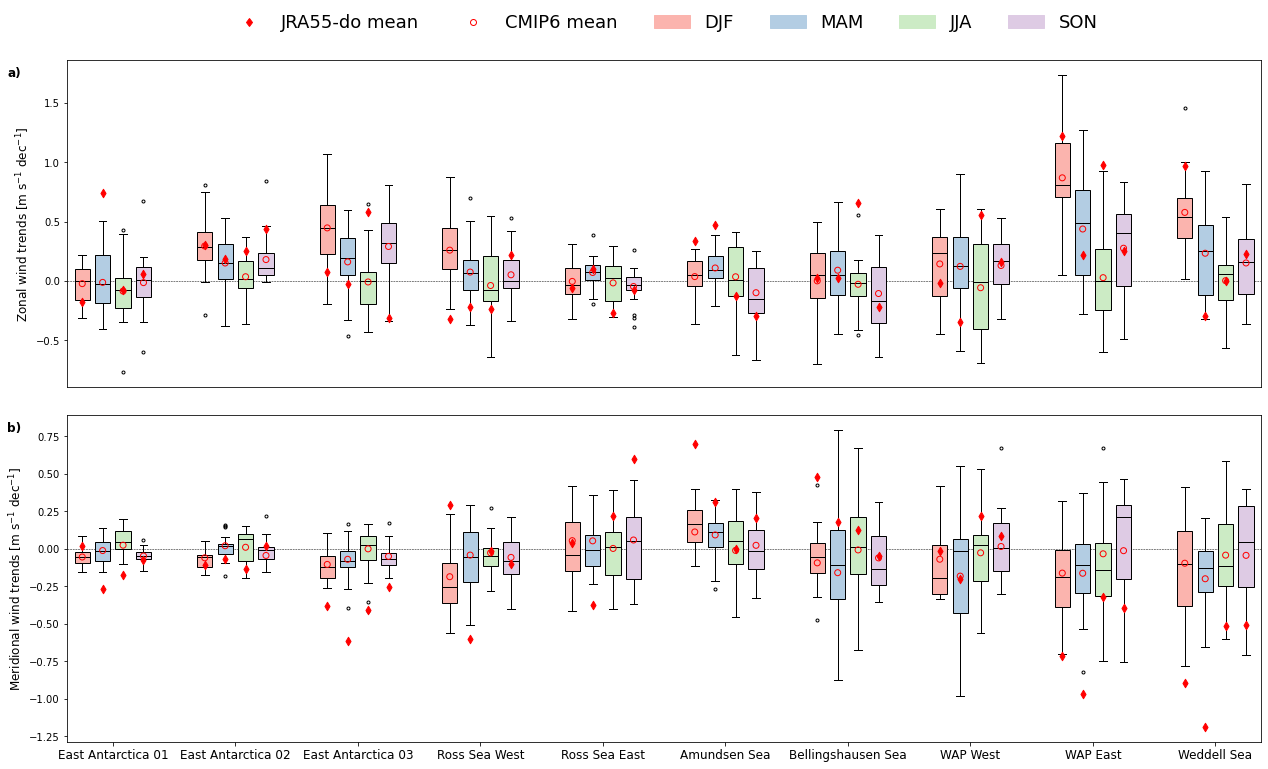

In [35]:
fig, axs = figure_4()
n = 0
for s in ['DJF', 'MAM', 'JJA', 'SON']:
    bp1 = axs[0].boxplot(uas_seasonal_trends_reg[s][2:,:]*120, positions = np.arange(0,40,4)+n/1.5, sym = '.', medianprops = dict(color = 'k'), 
                        patch_artist = True,zorder = 1);
    axs[0].scatter(np.arange(0,40,4)+n/1.5, uas_seasonal_trends_reg[s][0,:]*120, color = 'r', marker = 'd', zorder = 2)
    axs[0].scatter(np.arange(0,40,4)+n/1.5, uas_seasonal_trends_reg[s][1,:]*120, color = 'r',marker = 'o', facecolor = 'none', zorder = 2)
    
    bp2 = axs[1].boxplot(vas_seasonal_trends_reg[s][2:,:]*120, positions = np.arange(0,40,4)+n/1.5, sym = '.', medianprops = dict(color = 'k'), 
                         patch_artist = True, zorder = 1);
    axs[1].scatter(np.arange(0,40,4)+n/1.5, vas_seasonal_trends_reg[s][0,:]*120, color = 'r', marker = 'd', zorder = 2)
    axs[1].scatter(np.arange(0,40,4)+n/1.5, vas_seasonal_trends_reg[s][1,:]*120, color = 'r',marker = 'o', facecolor = 'none', zorder = 2)
    
    for bplot in (bp1, bp2):
        for patch, color in zip(bplot['boxes'], [Pastel1_4.mpl_colors[n]]*10):
            patch.set_facecolor(Pastel1_4.mpl_colors[n])
    n+=1
    plt.tight_layout()
axs[0].set_xticks([])
axs[0].set_xticklabels([]);
axs[1].set_xticks(np.arange(1, 41, 4))
axs[1].set_xticklabels(locs, fontsize = 12);
plt.legend(ncol = 6, handles = legend_elements, bbox_to_anchor = (0.5, 2.2), frameon = False, loc = 'center', fontsize = 18);
plt.savefig(figdir+'jratrends_cmip6trends_reg_boxplots_seasonal.png', facecolor = 'white', bbox_inches = 'tight')

# SSP 8.5

In [53]:
# CMIP6 multimodel mean
uas_ssp85 = {}
vas_ssp85 = {}
uas_ssp85['CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/ssp8.5/uas-ssp8.5-monthly-2015_2100.nc')
vas_ssp85['CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/ssp8.5/vas-ssp8.5-monthly-2015_2100.nc')

# CMIP6 individual models
path_uas = glob.glob('/scratch/e14/jn8053/cmip6/ssp8.5/uas-regrid/uas*')
path_vas = glob.glob('/scratch/e14/jn8053/cmip6/ssp8.5/vas-regrid/vas*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    uas_ssp85[model_name] = xr.open_dataset(path_uas[i])
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0][5:]
    vas_ssp85[model_name] = xr.open_dataset(path_vas[i])
model_names = list(uas_ssp85.keys())

In [54]:
# CMIP6 multimodel mean
uas_hist = {}
vas_hist = {}
uas_hist['CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/uas-hist-monthly-1958_2015.nc')
vas_hist['CMIP6'] = xr.open_dataset('/scratch/e14/jn8053/cmip6/historical/vas-hist-monthly-1958_2015.nc')

# CMIP6 individual models
path_uas = glob.glob('/scratch/e14/jn8053/cmip6/historical/uas-regrid/uas*')
path_vas = glob.glob('/scratch/e14/jn8053/cmip6/historical/vas-regrid/vas*')
for i in range(len(path_uas)):
    model_name = path_uas[i].split('/')[-1].split('_')[-1].split('.')[0]
    uas_hist[model_name] = xr.open_dataset(path_uas[i])
    
    model_name = path_vas[i].split('/')[-1].split('_')[-1].split('.')[0]
    vas_hist[model_name] = xr.open_dataset(path_vas[i])
model_names = list(uas_hist.keys())

In [62]:
uas_endofcentury = {}
vas_endofcentury = {}
for n in model_names:
    uas_endofcentury[n] = uas_ssp85[n].isel(time = slice(-20*12, None)).mean('time') - uas_hist[n].isel(time = slice(-20*12, None)).mean('time')
    vas_endofcentury[n] = vas_ssp85[n].isel(time = slice(-20*12, None)).mean('time') - vas_hist[n].isel(time = slice(-20*12, None)).mean('time')

In [69]:
uas_stacked = uas_endofcentury[model_names[1]]
vas_stacked = vas_endofcentury[model_names[1]]
for n in model_names[2:]:
    uas_stacked = xr.concat([uas_stacked, uas_endofcentury[n]], dim = 'model')
    vas_stacked = xr.concat([vas_stacked, vas_endofcentury[n]], dim = 'model')

In [75]:
def figure_5():
    fig = plt.figure(figsize = (15, 7))
    gr = gs.GridSpec(2, 3, figure = fig, width_ratios = [1, 1, .03])
    axs = [fig.add_subplot(gr[0,0]),
           fig.add_subplot(gr[0,1]),
           fig.add_subplot(gr[1,0]),
           fig.add_subplot(gr[1,1]),
           fig.add_subplot(gr[0,2]),
           fig.add_subplot(gr[1,2])]
    for ax, label in zip(axs[:4], ['a)', 'b)', 'c)', 'd)']):
        ax.text(-0.08, .95, label, transform=ax.transAxes, size = 12, weight='bold')
        ax.contour(hu['lon'], hu['lat'], hu, levels = [1000, 3000], colors = 'k', linewidths = 0.5, zorder = 2)
        ax.set_ylim(-80, -60)
        ax.set_yticks(np.arange(-80, -60, 5))

    plt.tight_layout()
    
    return fig, axs

In [78]:
uas_mean_eoc = uas_endofcentury['CMIP6'].interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
vas_mean_eoc = vas_endofcentury['CMIP6'].interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])

In [82]:
uas_std_eoc = uas_stacked.isel(model = slice(1, None)).std('model').interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])
vas_std_eoc = vas_stacked.isel(model = slice(1, None)).std('model').interp(lon = shelf_mask['lon'], lat = shelf_mask['lat'])

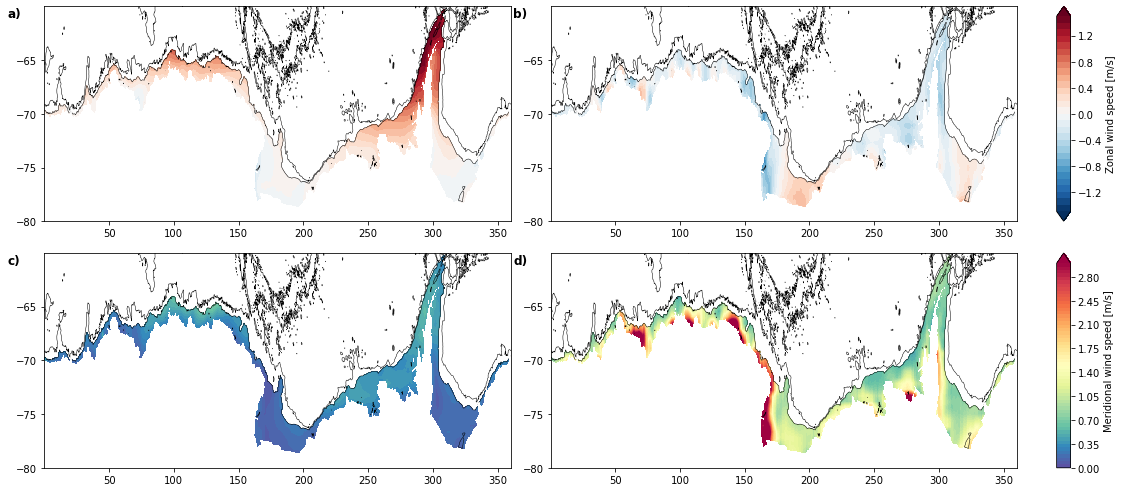

In [89]:
fig, axs = figure_5()
c = axs[0].contourf(uas_mean_eoc['lon'], uas_mean_eoc['lat'], uas_mean_eoc['uas']*shelf_mask, levels = np.arange(-1.5, 1.6, .1), cmap = 'RdBu_r', extend = 'both')
axs[1].contourf(vas_mean_eoc['lon'], vas_mean_eoc['lat'], vas_mean_eoc['vas']*shelf_mask, levels = np.arange(-1.5, 1.6, .1), cmap = 'RdBu_r', extend = 'both')
fig.colorbar(c, cax = axs[4], orientation = 'vertical').set_label('Zonal wind speed [m/s]')
c = axs[2].contourf(uas_std_eoc['lon'], uas_std_eoc['lat'], uas_std_eoc['uas']*shelf_mask, levels = np.arange(0, 3.05, .05), cmap = 'Spectral_r', extend = 'max')
axs[3].contourf(vas_std_eoc['lon'], vas_std_eoc['lat'], vas_std_eoc['vas']*shelf_mask, levels = np.arange(0, 3.05, .05), cmap = 'Spectral_r', extend = 'max')
fig.colorbar(c, cax = axs[5], orientation = 'vertical').set_label('Meridional wind speed [m/s]')
plt.savefig(figdir+'cmip6endofcentury.png', facecolor = 'white', bbox_inches = 'tight')